In [1]:
"""
    심층 강화학습(Deep Q Learning) + CNN_LSTM => Hyperparameter Optimization

    정리
    1. agent를 통해서 policy(랜덤값이 앱실론보다 작으면 랜덤 인덱스와 랜덤 action을, 
                            그렇지 않으면 내부 신경망(LSTM)에 state값을 넣어 
                            가능한 모든 action에 대한 action_values(Q_values) 중 가장 큰 값에 해당하는 인덱스와 그 값을 반환한다.
                            이때 사용되는 내부 신경망은 main_network이다.)
        에 맞는 action_index와 action_value를 찾아낸다.
    2. 찾아낸 action_index와 action_value를 env에 넣어서 RF 모델을 돌린 뒤 next_state(다음 action 집합)와 reward(정확도)를 찾아낸다.
    3. memory(replay buffer)에 현재 state와 action_index, 그리고 위에서 도출된 next_state, reward를 넣는다.
    4. replay buffer에서 원하는 batch size만큼 sample(state, action_index, reward, next_state)을 뽑아낸다.
    5. sample의 state를 main_network에 넣어서 도출된 값들 중 action index에 맞는 값을 뽑고 이를 main Q 값으로 한다.
    6. sample의 next_state를 target_network에 넣어서 값을 도출한 뒤, 그 중 가장 큰 값을 찾아낸다.
    7. 위에서 찾아낸 값을 Q라고 한다면, reward + gamma(discount factor)*Q = target Q로 정한다.
    8. mainQ와 targetQ를 loss function에 넣어서 내부 신경망 파라미터를 역전파로 업데이트 한다. 이때 옵티마이저도 사용된다.
    9. 이 과정을 반복하여 main Q가 target Q에 가까워질 수 있게 한다.
    
    
    
    신경망 성능 상승 (현재: CNN+LSTM)
    1. CNN+GRU 사용 -> 100,1000 기준으로는 더 성능이 안좋다.
    2. LSTM만 사용 
    3. GRU만 사용
    4. Transformer 사용
    5. discount factor 변경 (0.99 -> 0.7) : reward의 영향을 더 크게 만든다.
    6. batch_size 변경
"""

"""    
    더 나아가서,
    1. multi agent를 사용해야하나?
    
    state 설정
    만약 넣은 state가 100,None,2,1,0,0(defalut) 라면, action value는 
    3^6=729개의 조합에 대해 q-value를 뽑고 그 중 하나를 고르는 것.
    따라서 state는 (729, 6)의 크기를 갖는다.
    
    deep q 이유
    만약 일반 q learning을 쓸 때, 
    하나의 하이퍼파라미터 당 10개의 tracking을 한다고 가정하면, 10^6만큼의 q-table이 필요하게 된다.
    따라서 시/공간 효율성을 위해 하이퍼파라미터 조합에 대한 q-value 값을 표현해주는 신경망을 학습시키는 것이 도움이 될 수 있다.
    
    장점
    1. 기존 hyperparameter tunning 방식은 내가 가능한 조합을 미리 설계해주어야 했다. 그래서 경험적으로 가능한 조합에 대한 지식이 있어야한다.
       하지만 강화학습에서는 step을 통해 조합을 찾으므로 미리 가능한 조합을 설계해둘 필요가 없다.
    2. 학습된 모델을 데이터가 추가된 경우에도 그대로 사용할 수 있다.
    3. 한번 만들어두면 시간 효율적이다.
    4. 학습된 모델을 파인튜닝하여 사용할 수 있다.
    5. 기존 방식은 내가 조합을 미리 제한해두기 때문에 최적의 조합인지에 대한 확신을 가지기 어렵다.
    6. 인간이 어떤 문제에 대해서 해결을 할 때, 모든 경우의 수를 모두 반복하지 않고 기존 경험을 통해 최선의 몇가지 방법만을 반복한다.
        DQL을 사용한 하이퍼파라미터 튜닝은 이와 같은 추상화 방식을 사용하며, 기존 경험을 통해 다음 결정을 유도하는 방식이다.
"""



'    \n    더 나아가서,\n    1. multi agent를 사용해야하나?\n    \n    state 설정\n    만약 넣은 state가 100,None,2,1,0,0(defalut) 라면, action value는 \n    3^6=729개의 조합에 대해 q-value를 뽑고 그 중 하나를 고르는 것.\n    따라서 state는 (729, 6)의 크기를 갖는다.\n    \n    deep q 이유\n    만약 일반 q learning을 쓸 때, \n    하나의 하이퍼파라미터 당 10개의 tracking을 한다고 가정하면, 10^6만큼의 q-table이 필요하게 된다.\n    따라서 시/공간 효율성을 위해 하이퍼파라미터 조합에 대한 q-value 값을 표현해주는 신경망을 학습시키는 것이 도움이 될 수 있다.\n    \n    장점\n    1. 기존 hyperparameter tunning 방식은 내가 가능한 조합을 미리 설계해주어야 했다. 그래서 경험적으로 가능한 조합에 대한 지식이 있어야한다.\n       하지만 강화학습에서는 step을 통해 조합을 찾으므로 미리 가능한 조합을 설계해둘 필요가 없다.\n    2. 학습된 모델을 데이터가 추가된 경우에도 그대로 사용할 수 있다.\n    3. 한번 만들어두면 시간 효율적이다.\n    4. 학습된 모델을 파인튜닝하여 사용할 수 있다.\n    5. 기존 방식은 내가 조합을 미리 제한해두기 때문에 최적의 조합인지에 대한 확신을 가지기 어렵다.\n    6. 인간이 어떤 문제에 대해서 해결을 할 때, 모든 경우의 수를 모두 반복하지 않고 기존 경험을 통해 최선의 몇가지 방법만을 반복한다.\n        DQL을 사용한 하이퍼파라미터 튜닝은 이와 같은 추상화 방식을 사용하며, 기존 경험을 통해 다음 결정을 유도하는 방식이다.\n'

In [2]:
import gym
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import copy
from itertools import product
import torch
from torch import nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
random.seed(42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_wine
from scipy.stats import t

class h2y2_RF_Model():
    def __init__(self, cur_hyperparameter, edit, new):
        self.model = RandomForestClassifier(**cur_hyperparameter, random_state=42)
        x_data, y_data = self.get_data(edit, new)
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

    # 신뢰구간을 구하는 함수
    def get_interval(self, data, confidence):
        n = len(data)
        dof = n-1 # 자유도
        mean = np.mean(data)
        
        sample_std = np.std(data, ddof = 1)
        std_err = sample_std / n ** 0.5

        CI = t.interval(confidence, dof, loc = mean, scale = std_err)
        return CI

    # 원하는 범위의 실수값을 n개 sample하는 함수
    def n_sample_float(self, n, ci):
        sample_result = []
        for _ in range(n):
            sample_result.append(random.uniform(ci[0], ci[1]))
        return sample_result

    # 데이터를 추가하는 함수 (95% 신뢰구간에서 랜덤으로 추출)
    def add_data(self, data):
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['target'] = data.target
        data_0 = df[df['target'] == 0]
        data_1 = df[df['target'] == 1]
        add_df_0 = pd.DataFrame(columns = df.columns)
        add_df_1 = pd.DataFrame(columns = df.columns)
        # 데이터는 각각 label당 5%씩 추가한다.
        for fn in data.feature_names:
            fn_ci_0 = self.get_interval(data_0[fn], 0.95)
            fn_add_list_0 = self.n_sample_float(max(1,int(len(data_0)*0.05)), fn_ci_0)
            add_df_0[fn] = fn_add_list_0
            fn_ci_1 = self.get_interval(data_1[fn], 0.95)
            fn_add_list_1 = self.n_sample_float(max(1,int(len(data_1)*0.05)), fn_ci_1)
            add_df_1[fn] = fn_add_list_1
        add_df_0['target'] = 0
        add_df_1['target'] = 1
        
        return pd.concat([df,add_df_0,add_df_1])

    def get_data(self, edit, new):
        data = load_breast_cancer()
        if edit:
            data = self.add_data(data)
            data.to_csv('./data/new_data.csv')
            x_data = data.drop(['target'], axis=1)
            y_data = data['target']
        elif new:
            data = pd.read_csv('./data/Heart_Disease_Prediction.csv')
            x_data = data.drop(['Heart Disease'], axis=1)
            y_data = data['Heart Disease']
            # data = load_wine()
            # x_data = pd.DataFrame(data.data, columns=data.feature_names)
            # y_data = data.target
        else:
            x_data = pd.DataFrame(data.data, columns=data.feature_names)
            y_data = data.target
        return x_data, y_data

    def evaluate(self):
        self.model.fit(self.train_x, self.train_y)
        predict = self.model.predict(self.test_x)
        return accuracy_score(self.test_y, predict)
    

In [5]:
class H2Y2_env:
    
    def __init__(self):
        # initial
        self.comb_config = [[-50,0,50], [-2,0,2], [-1,0,1], [-1,0,1], [-0.1,0,0.1], [-0.1,0,0.1]]
        self.hyperparameter_list = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'min_impurity_decrease']
        self.epsilon = 1e-2
    
    # 하이퍼파라미터의 범위를 제한해주는 함수 ver1
    def check_bound(self, comb):        
        comb_sum = comb[1] + comb[2]
        if comb[0] == 'n_estimators':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'max_depth':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'min_samples_leaf':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'min_samples_split':
            if comb_sum > 1:
                return int(comb_sum)
        elif comb[0] == 'min_weight_fraction_leaf':
            if comb_sum >= 0 and comb_sum <= 0.5:
                return float(comb_sum)
        elif comb[0] == 'min_impurity_decrease':
            if comb_sum >= 0 and comb_sum <= 1:
                return float(comb_sum)
        return comb[1]
    
    # 하이퍼파라미터의 범위를 제한해주는 함수 ver2
    def check_bound_ver2(self, comb):
        sample_state = []
        for i in range(len(comb[2])):
            comb_sum = comb[1] + comb[2][i]
            if comb[0] == 'n_estimators':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'max_depth':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_samples_leaf':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_samples_split':
                if comb_sum > 1:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_weight_fraction_leaf':
                if comb_sum >= 0 and comb_sum <= 0.5:
                    sample_state.append(float(comb_sum))
            elif comb[0] == 'min_impurity_decrease':
                if comb_sum >= 0 and comb_sum <= 1:
                    sample_state.append(float(comb_sum))
            else:
                sample_state.append(comb[1])
        return sample_state
    
    # hyper-parameter vector를 받아서 다음으로 가능한 모든 조합을 반환해주는 함수
    def make_state(self, cur_comb):
        comb = list(product(*self.comb_config))
        state = [tuple(map(self.check_bound, zip(self.hyperparameter_list, cur_comb, tuple_comb))) for tuple_comb in comb]
        # print(state)
        return state
        
    # q_value로 도출된 action_index가 어떤 observation을 가리키는지 확인한다.
    def mapping_action(self, state, action_index):
        all_state = list(product(*state))
        # print(len(all_state))
        return all_state[action_index]
        
    # hyper-parameter vector를 받아서 파라미터마다 가능한 값을 2차원으로 반환해주는 함수 ex)[[90, 100, 110], [2, 4, 6], [20, 25, 30], ...]
    def make_state_ver2(self, cur_comb):
        state = []
        for name, cur, comb in zip(self.hyperparameter_list, cur_comb, self.comb_config):
            state.append(self.check_bound_ver2([name,cur,comb]))
        # print(state)
        return state
    
    # env의 초기 state 설정, state는 hyper-parameter의 가능한 모든 조합으로 정의한다.
    def reset(self):
        init_hp = [random.randint(1, 100), random.randint(1, 100), random.randint(2, 100), random.randint(1, 100), random.random()/2, random.random()]
        state = self.make_state(init_hp)
        return state
        
    # action을 넣어서 next_state와 reward를 반환하는 함수
    def step(self, state, action_index, edit, new):
        done = 0
        cur_comb = state[action_index]
        cur_hyperparameter = dict(zip(self.hyperparameter_list, cur_comb))
        rf_model = h2y2_RF_Model(cur_hyperparameter, edit, new)
        reward = rf_model.evaluate()
        next_state = self.make_state(cur_comb)
        if reward == 1-self.epsilon:
            done = 1
        return next_state, reward, done

    # action을 넣어서 next_state와 reward를 반환하는 함수 ver2
    def step_ver2(self, state, action_index, edit, new):
        done = 0
        cur_comb = self.mapping_action(state, action_index) # state에 맞게 현재 조합 매핑
        cur_hyperparameter = dict(zip(self.hyperparameter_list, cur_comb))
        rf_model = h2y2_RF_Model(cur_hyperparameter, edit, new)
        reward = rf_model.evaluate()
        next_state = self.make_state_ver2(cur_comb)
        if reward == 1-self.epsilon:
            done = 1
        return next_state, reward, done
        

In [6]:
class H2Y2_Agent:
    def __init__(self):
        self.gamma = 0.7 # discount factor
        self.t_step = 0
        self.learn_freq = 4
        self.target_update_freq = 1000
        self.batch_size = 32
        self.action_size = 6

        self.main_network = Network(input_size=(729,6), out_size=729).float().to(device)
        self.target_network = Network(input_size=(729,6), out_size=729).float().to(device)
        self.target_network.load_state_dict(self.main_network.state_dict())
        
        self.hidden_state, self.cell_state = self.main_network.init_hidden_states(bsize=1)
        self.memory = ReplayBuffer(action_size = self.action_size, buffer_size = 10000, batch_size = self.batch_size, seed=42)
        self.optimizer = optim.Adam(self.main_network.parameters(), lr = 0.01)

    
    def select_action(self, state, eps=0.):
        # "내부의 신경망에 state를 넣어 모든 q_value를 뽑고, argmax로 선택"
        
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)
        self.main_network.eval()
        with torch.no_grad(): # 연산속도 증가
            action_values, _ = self.main_network.forward(state, bsize=1, time_step=1, hidden_state=self.hidden_state, cell_state=self.cell_state)
            # print(type(action_values)) # tuple
        self.main_network.train()
    
        # q_value를 최대로 만드는 action의 인덱스를 선택한다.
        if random.random() > eps:
            max_index = torch.argmax(action_values)
            return max_index
        else:
            random_index = random.choice(np.arange(self.action_size))
            return random_index
            
    def step(self, state, action_index, reward, next_state, done):
        # 메모리에 현재의 state, action_index, reward, next_state, done을 추가한다.
        self.t_step += 1 
        # print(self.t_step) # t_step은 episode가 바뀌어도 유지된다.
        self.memory.add(state, action_index, reward, next_state, done)
        
        # target_update로 정해둔 step마다, target network의 파라미터를 업데이트 한다.
        if (self.t_step % self.target_update_freq) == 0:
            self.target_network.load_state_dict(self.main_network.state_dict())
            
        # learn_freq로 정해둔 step마다, batch_size만큼의 샘플을 가지고 main_network를 학습시킨다.
        if (self.t_step % self.learn_freq) == 0:
            # batch_size만큼의 sample이 memory에 있으면 학습을 실행한다.
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
    
    # main_network의 파라미터를 학습하는 함수
    def learn(self, experiences, gamma):
        states, actions, reward, next_states, dones = experiences
        hidden_batch, cell_batch = self.main_network.init_hidden_states(bsize=self.batch_size)

        # target_network를 통해 next_state에 대한 q_value 값을 도출하고, 그 중 max인 값을 선택한다.
        Q_targets_next, _ = self.target_network.forward(next_states,bsize=self.batch_size, time_step=1, hidden_state=hidden_batch, cell_state=cell_batch)
        Q_targets_next_max, __ = Q_targets_next.detach().max(dim=1)
        Q_targets_next_max = Q_targets_next_max.view(-1,1)
        # print(Q_targets_next_max.shape) # torch.Size([23328, 1]) -> torch.Size([32, 1])이 나와야함. -> 완료
        
        # q_value_target을 계산한다.
        Q_targets = reward + (gamma * Q_targets_next_max)
        # print(Q_targets.shape) # (32,1)

        # main_network를 통해 현재 state와 action 대한 q_value를 도출한다.
        Q_expected, _ = self.main_network.forward(states, bsize=self.batch_size, time_step=1, hidden_state=hidden_batch, cell_state=cell_batch)

        # print(Q_expected.shape) # (32,729)
        Q_expected_action = Q_expected.gather(dim=1, index = actions)
        # print(Q_expected_action.shape) # (32,1)
        
        # print(f"current: {Q_expected_action[0]}, \n target: {Q_targets[0]}")
        
        loss = F.mse_loss(Q_expected_action, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [7]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size #각각의 action의 차원
        self.memory = deque(maxlen=buffer_size)  #버퍼의 최대 크기
        self.batch_size = batch_size # 배치 사이즈
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed) # 랜덤 시드
    
    # states, actions, rewards, next_states, done을 replay memory에 저장하는 함수
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # replay memory에서 이전 과정에서 저장된 states, actions, rewards, next_states, done을 랜덤 추출하는 함수
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([torch.as_tensor(e.state).cpu() for e in experiences if e is not None])).float().to(device)
        # print(states.shape) # (32*729,6)
        actions = torch.from_numpy(np.vstack([torch.as_tensor(e.action).cpu() for e in experiences if e is not None])).long().to(device)
        # print(actions.shape) # (32,1)
        rewards = torch.from_numpy(np.vstack([torch.as_tensor(e.reward).cpu() for e in experiences if e is not None])).float().to(device)
        # print(rewards.shape) # (32,1)
        next_states = torch.from_numpy(np.vstack([torch.as_tensor(e.next_state).cpu() for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([torch.as_tensor(e.done).cpu() for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        # print(dones.shape) # (32,1)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [8]:
# lstm

class LSTM(nn.Module):
    
    def __init__(self,input_size,out_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        self.lstm_layer = nn.LSTM(input_size = 729, )
        self.relu = nn.ReLU()

In [9]:
# gru

class GRU(nn.Module):
    def __init__(self, input_size, out_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        

In [10]:
# cnn+lstm network

class Network(nn.Module):
    
    def __init__(self,input_size,out_size):
        super(Network,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        self.conv_layer1 = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=8,stride=4)
        self.conv_layer2 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=4,stride=2)
        self.conv_layer3 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.conv_layer4 = nn.Conv1d(in_channels=64,out_channels=512,kernel_size=7,stride=1)
        self.lstm_layer = nn.LSTM(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
        self.adv = nn.Linear(in_features=512,out_features=self.out_size)
        self.val = nn.Linear(in_features=512,out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x,bsize,time_step,hidden_state,cell_state):
        x = x.view(bsize*time_step,1,-1)
        
        conv_out = self.conv_layer1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer3(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer4(conv_out)
        conv_out = self.relu(conv_out)
        # print(conv_out.shape) # [1,512,~]
        
        conv_out = conv_out.view(bsize, -1, 512)
        
        lstm_out = self.lstm_layer(conv_out,(hidden_state,cell_state))
        out = lstm_out[0][:,time_step-1,:]
        h_n = lstm_out[1][0]
        c_n = lstm_out[1][1]
        
        adv_out = self.adv(out)
        val_out = self.val(out)
        
        qout = val_out.expand(bsize,self.out_size) + (adv_out - adv_out.mean(dim=1).unsqueeze(dim=1).expand(bsize,self.out_size))
        
        return qout, (h_n,c_n)
    
    def init_hidden_states(self,bsize):
        h = torch.zeros(1,bsize,512).float().to(device)
        c = torch.zeros(1,bsize,512).float().to(device)
        
        return h,c

In [11]:
# cnn + gru network

class GRU_Network(nn.Module):
    def __init__(self,input_size,out_size):
        super(GRU_Network,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        self.conv_layer1 = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=8,stride=4)
        self.conv_layer2 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=4,stride=2)
        self.conv_layer3 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.conv_layer4 = nn.Conv1d(in_channels=64,out_channels=512,kernel_size=7,stride=1)
        self.gru_layer = nn.GRU(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
        self.adv = nn.Linear(in_features=512,out_features=self.out_size)
        self.val = nn.Linear(in_features=512,out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x,bsize,time_step,hidden_state,cell_state):
        x = x.view(bsize*time_step,1,-1)
        
        conv_out = self.conv_layer1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer3(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer4(conv_out)
        conv_out = self.relu(conv_out)
        # print(conv_out.shape) # [1,512,~]
        
        conv_out = conv_out.view(bsize, -1, 512)
        
        gru_out, h_n = self.gru_layer(conv_out,hidden_state)
        out = gru_out[:,time_step-1,:]
        
        adv_out = self.adv(out)
        val_out = self.val(out)
        
        qout = val_out.expand(bsize,self.out_size) + (adv_out - adv_out.mean(dim=1).unsqueeze(dim=1).expand(bsize,self.out_size))
        
        return qout, h_n
    
    def init_hidden_states(self,bsize):
        h = torch.zeros(1,bsize,512).float().to(device)
        c = torch.zeros(1,bsize,512).float().to(device)
        
        return h,c

In [12]:
# transformer network

class TransformerNetwork(nn.Module):
    def __init__(self):
        super(TransformerNetwork,self).__init__()
        self.transformer_layer = nn.Transformer()

In [13]:
# simple network
q_network = nn.Sequential(
    nn.Linear(6, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

In [14]:
class H2Y2:
    def __init__(self, edit=False, new=False):
        self.agent = H2Y2_Agent()
        self.env = H2Y2_env()
        self.eps = 1.0 # 처음 epsilon
        self.scores = []
        self.end_times = []
        self.edit = edit
        self.new = new
        
    def dqn(self, n_episodes=10, max_t=10, eps_end=0.01, eps_decay=0.99):
            
        for i_episode in tqdm(range(1, n_episodes+1)):
            print(f"{i_episode} episode")
            state = self.env.reset()
            score = 0
            for t in range(1,max_t+1):
                # print(f"{t} time")
                action_index = self.agent.select_action(state, self.eps)
                next_state, reward, done = self.env.step(state, action_index, self.edit, self.new)
                self.agent.step(state, action_index, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            self.scores.append(score) # 하나의 episode에 대한 score(reward)를 저장
            self.end_times.append(t) # 몇번의 step을 통해 done에 도달하는지 확인
            self.eps = max(eps_end, eps_decay*self.eps) # decrease epsilon

            if i_episode % 5 == 0:
                torch.save(self.agent.main_network.state_dict(),f'./model/{i_episode}_cpu_test.pt') 
        # model save
        torch.save(self.agent.main_network.state_dict(),'./model/cpu_test.pt')
        return np.mean(self.scores)

In [ ]:
# 모델 학습

h2y2 = H2Y2()

h2y2.dqn()

In [38]:
# 강화학습모델의 파라미터를 불러와서 목표 모델의 하이퍼파라미터를 튜닝하는 함수
def h2y2_optimization(model, max_t, edit=False, new=False):
    h2y2_test = H2Y2(edit, new)
    weights = torch.load(f'./model/{model}', map_location='cpu')
    h2y2_test.agent.main_network.load_state_dict(weights)
    max_score = 0
    scores = []
    done_t = []

    for episode in range(1):
        state = h2y2_test.env.reset()
        for t in range(1,max_t+1):
            action_index = h2y2_test.agent.select_action(state, 0.01)
            next_state, reward, done = h2y2_test.env.step(state, action_index, edit, new)
            state = next_state
            scores.append(reward)
            max_score = max(max_score, reward)
            done_t.append(done)
            if done:
                break
    
    return scores, max_score, done_t

scores, max_score, dones = h2y2_optimization('CNN_LSTM_WEIGHTS_100episodes_10000max_t.pt', 100, edit=False)

# 1000번 step에 2분 소요
# 500번 step에 1분 소요
# 100번 step에 15초 소요


0.9532163742690059


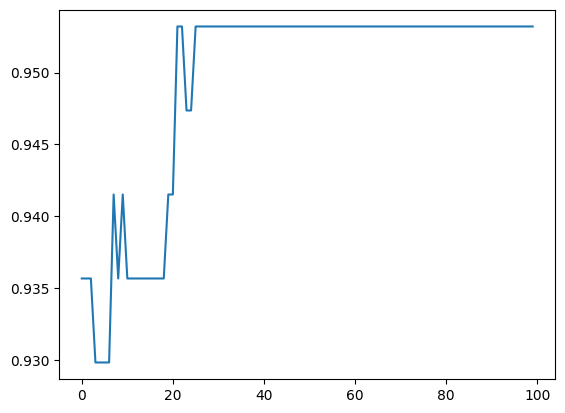

In [39]:
import matplotlib.pyplot as plt

print(max_score)
plt.plot(scores)

In [ ]:
# gru network에서 테스트


In [38]:
# grid search
from sklearn.model_selection import GridSearchCV

grid_search = {'n_estimators': [10, 50, 100, 150, 200],
               'max_depth': [2, 4, 6, 8, 10],
               'min_samples_leaf': [1, 2, 3, 4, 5],
               'min_samples_split': [2, 3, 4, 5, 6],
               'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
               'min_impurity_decrease': [0.1, 0.2, 0.3, 0.4, 0.5],
               }
data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
grid_model = GridSearchCV(estimator = clf, param_grid = grid_search, scoring='accuracy')
grid_model.fit(train_x,train_y)
predict = grid_model.best_estimator_.predict(test_x)

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 돌렸을 때 (5^6 = 15625),
# 시간은 정말 많이...(1번당 5초가 걸린다고 했을 때, 15625*5초 = 21시간) 소요된다.



# 하이퍼파라미터 6개를 각각 3개씩 지정하여 돌렸을 때, (3^6 = 729)
# 시간은 5분이 걸린다.

# 단점: 모든 조합을 다 해볼 순 있지만 시간이 매~우 많이 걸리고,
#       다 해봤다고 하더라도 내가 지정해준 조합 내에서만 움직이는 것이므로 최적을 보장할 순 없음.

0.9220886075949366


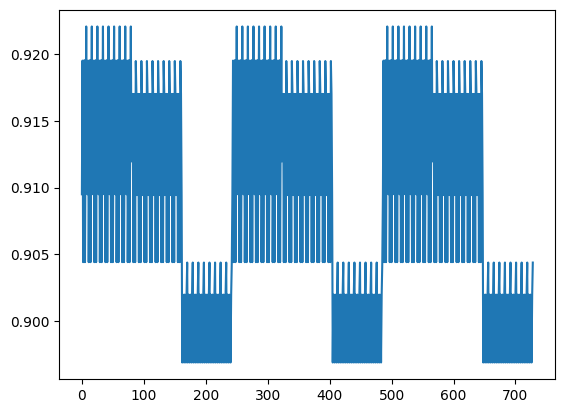

In [ ]:
# grid search 결과 시각화
import pandas as pd
df = pd.DataFrame(grid_model.cv_results_)
grid_score = df['mean_test_score']

print("\nGrid Search : ", grid_model.best_score_)
plt.plot(grid_score)

In [27]:
# random search (주어진 범위 내에서 임의의 조합을 선택하여 최적의 조합을 탐색)
from sklearn.model_selection import RandomizedSearchCV

random_search = {'n_estimators': list(map(int,(np.linspace(10,1000,100)))),
               'max_depth': list(map(int,np.linspace(2,100,98))),
               'min_samples_leaf': list(map(int, np.linspace(1,100,99))),
               'min_samples_split': list(map(int,np.linspace(2,100,98))),
               'min_weight_fraction_leaf': list(np.linspace(0.1,0.5,5)),
               'min_impurity_decrease': list(np.linspace(0.1,0.9,9)),
               }

data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
random_model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, random_state= 42, scoring='accuracy')
random_model.fit(train_x,train_y)
predict = random_model.best_estimator_.predict(test_x)

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 iteration을 100번 돌렸을 때,
# 시간은 1분 20초가 소요된다.


Random Search :  0.9222151898734177


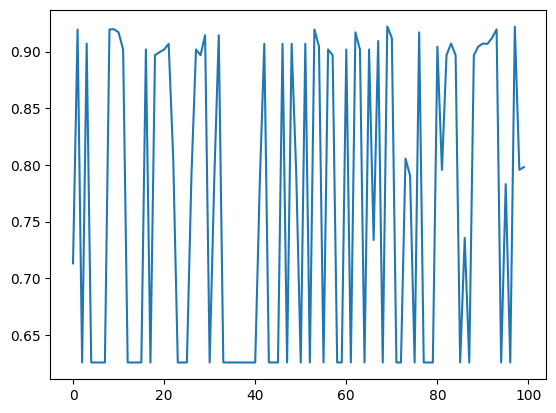

In [28]:
# random search 결과 시각화
import pandas as pd
df = pd.DataFrame(random_model.cv_results_)

print("\nRandom Search : ", random_model.best_score_)
random_score = df['mean_test_score']

plt.plot(random_score)

In [29]:
# Bayesian optimization ver1

# 목적 함수
from sklearn.metrics import r2_score, mean_squared_error

def bayes_rf(n_estimators, max_depth, min_samples_leaf, min_samples_split, min_weight_fraction_leaf, min_impurity_decrease):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth = int(max_depth),
        min_samples_leaf = int(min_samples_leaf),
        min_samples_split = int(min_samples_split),
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        min_impurity_decrease = min_impurity_decrease,
        random_state=42)
    
    data = load_breast_cancer()
    x_data = pd.DataFrame(data.data, columns=data.feature_names)
    y_data = data.target
    train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
    
    model.fit(train_x,train_y)
    y_pred= model.predict(test_x)
    
    score=accuracy_score(y_pred, test_y)
    
    return score

In [ ]:
# 베이지안 최적화 실행 ver1
from bayes_opt import BayesianOptimization, UtilityFunction

Bayesian_search = {'n_estimators': [10, 1000],
               'max_depth': [2, 100],
               'min_samples_leaf': [1, 100],
               'min_samples_split': [2, 100],
               'min_weight_fraction_leaf': [0.1, 0.5],
               'min_impurity_decrease': [0.1, 0.9]
               }
               
bo = BayesianOptimization(f=bayes_rf, pbounds=Bayesian_search, verbose=0, random_state=42)
bo.maximize(init_points=2, n_iter=100)

max_parameter = bo.max['params']
max_parameter['n_estimators']=int(max_parameter['n_estimators'])
max_parameter['max_depth']=int(max_parameter['max_depth'])
max_parameter['min_samples_leaf']=int(max_parameter['min_samples_leaf'])
max_parameter['min_samples_split']=int(max_parameter['min_samples_split'])


bo_tuned_rf = RandomForestClassifier(**max_parameter)
data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

bo_tuned_rf.fit(train_x,train_y)
y_pred= bo_tuned_rf.predict(test_x)
print("\nBayesian Search : ", accuracy_score(test_y, y_pred))

# 하이퍼파라미터 6개 iteration을 100번 돌렸을 때, 
# 시간은 초가 소요된다.
# 정확도는 Bayesian Search :  0.9473684210526315


In [48]:
# 베이지안 최적화 과정 시각화 함수
import matplotlib.pyplot as plt
from matplotlib import gridspec
from bayes_opt import BayesianOptimization, UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [36]:
# Bayesian optimization ver2
from skopt import BayesSearchCV

data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

Bayesian_search = {'n_estimators': list(map(int,(np.linspace(10,1000,100)))),
               'max_depth': list(map(int,np.linspace(2,100,98))),
               'min_samples_leaf': list(map(int, np.linspace(1,100,99))),
               'min_samples_split': list(map(int,np.linspace(2,100,98))),
               'min_weight_fraction_leaf': list(np.linspace(0.1,0.5,5)),
               'min_impurity_decrease': list(np.linspace(0.1,0.9,9)),
               }

clf = RandomForestClassifier(random_state=42)

bayesian_model = BayesSearchCV(
    clf,
    Bayesian_search,
    n_iter=100,
    random_state=42,
    scoring='accuracy',
)

bayesian_model.fit(train_x, train_y)

# iteration을 100번 돌렸을 때,
# 시간은 11분 14초가 소요된다.
# 정확도는 Bayesian Search : 0.9246835443037975

# iteration을 300번 돌렸을 때,
# 시간은 1시간 31분이 소요된다.
# 정확도는 bayesian Search :  0.9321835443037975

# 단점 : 

BayesSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=100,
              random_state=42, scoring='accuracy',
              search_spaces={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                           13, 14, 15, 16, 17, 18, 19, 20, 21,
                                           22, 23, 24, 25, 26, 27, 28, 29, 30,
                                           31, ...],
                             'min_impurity_decrease': [0.1, 0.2,
                                                       0.30000000000000004, 0.4,
                                                       0.5, 0.6,
                                                       0.7000000000000001, 0.8,
                                                       0.9],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 6,...
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...],
                             'min_weight_fraction_leaf': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5],
                             'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100, 110, 120, 130, 140, 150,
                                              160, 170, 180, 190, 200, 210, 220,
                                              230, 240, 250, 260, 270, 280, 290,
                                              300, ...]})


bayesian Search :  0.9246518987341773


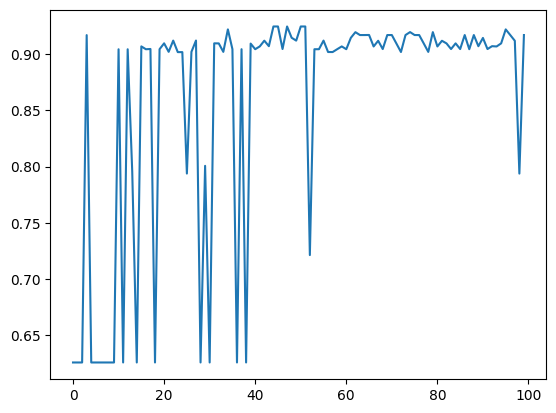

In [37]:
# Bayesian search 결과 시각화
import pandas as pd
import matplotlib.pyplot as plt

print("\nbayesian Search : ", bayesian_model.best_score_)

df = pd.DataFrame(bayesian_model.cv_results_)
bayesian_score = df['mean_test_score']

plt.plot(bayesian_score)

In [34]:
# Genetic Algorithm
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd

GA_grid = {'n_estimators': Integer(10, 1000),
               'max_depth': Integer(2, 100),
               'min_samples_leaf': Integer(1, 100),
               'min_samples_split': Integer(2, 100),
               'min_weight_fraction_leaf': Continuous(0.1, 0.5, distribution='log-uniform'),
               'min_impurity_decrease': Continuous(0.1, 0.9, distribution='log-uniform'),
               }
clf = RandomForestClassifier(random_state=42)
ga_model = GASearchCV(estimator=clf,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid= GA_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               keep_top_k=4)

data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

ga_model.fit(train_x, train_y)

# generations을 35로 설정했을 때,
# 시간은 7분 14초가 소요된다.
# 정확도는 Genetic algorithm :  0.9221728563833826

seaborn not found, pip install seaborn to use plots functions


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.76405	0.138458   	0.909604   	0.625636   
1  	18    	0.903966	0.00222204 	0.909604   	0.901914   
2  	16    	0.906765	0.00290632 	0.912091   	0.904458   
3  	19    	0.908791	0.0037788  	0.914597   	0.904458   
4  	19    	0.910317	0.00255858 	0.912091   	0.904458   
5  	20    	0.912341	0.00075188 	0.914597   	0.912091   
6  	19    	0.913849	0.00196378 	0.917122   	0.912091   
7  	17    	0.914352	0.00208941 	0.917122   	0.912091   
8  	16    	0.91611 	0.00166821 	0.917122   	0.912091   
9  	18    	0.91712 	5.69606e-06	0.917122   	0.917103   
10 	20    	0.917122	1.11022e-16	0.917122   	0.917122   
11 	19    	0.918132	0.0020202  	0.922173   	0.917122   
12 	18    	0.920153	0.00247423 	0.922173   	0.917122   
13 	18    	0.922173	2.22045e-16	0.922173   	0.922173   
14 	20    	0.922173	2.22045e-16	0.922173   	0.922173   
15 	15    	0.922173	2.22045e-16	0.922173   	0.922173   
16 	18    	0.922173	2.22045e-16	0.922173   	0.9221

GASearchCV(crossover_probability=0.8,
           estimator=RandomForestClassifier(max_depth=93,
                                            min_impurity_decrease=0.23389605199702712,
                                            min_samples_leaf=71,
                                            min_samples_split=36,
                                            min_weight_fraction_leaf=0.27697140462763925,
                                            n_estimators=71, random_state=42),
           generations=35, keep_top_k=4, mutation_probability=0.1, n_jobs=-1,
           param_grid={'max_depth': <sklearn_genetic.sp...
                       'min_samples_leaf': <sklearn_genetic.space.space.Integer object at 0x0000017491E3D2A0>,
                       'min_samples_split': <sklearn_genetic.space.space.Integer object at 0x00000174951351B0>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x000001748ED8F0A0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x00000174948FCF40>},
           population_size=10, return_train_score=True, scoring='accuracy')


Genetic algorithm :  0.9221728563833826


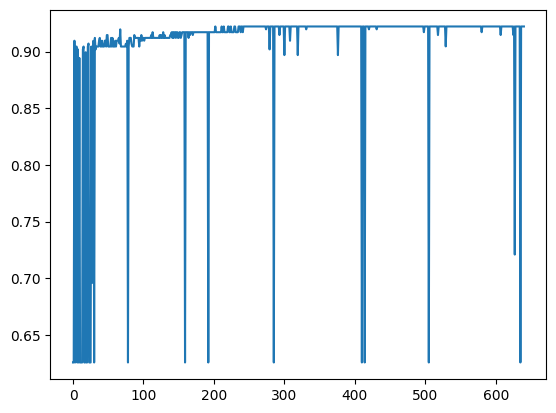

In [35]:
# GA 결과 시각화
import pandas as pd

print("\nGenetic algorithm : ", ga_model.best_score_)

df = pd.DataFrame(ga_model.cv_results_)
ga_score = df['mean_test_score']

plt.plot(ga_score)

In [ ]:
# 결론
# DQL을 사용한 하이퍼파라미터 튜닝의 성능이 가장 좋게 나온다.

In [17]:
data = load_breast_cancer()
print(len(data.data))

569


0.9608938547486033


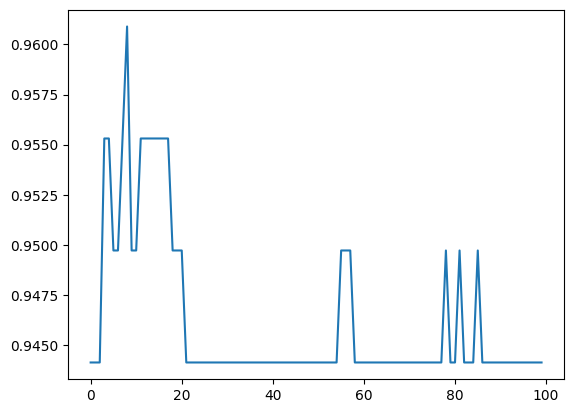

In [53]:
# DQL을 활용해서 RF모델을 학습시키는 데이터가 추가되었을 때도 잘 동작하는지 확인
import matplotlib.pyplot as plt
scores, max_score, dones = h2y2_optimization('CNN_LSTM_WEIGHTS_100episodes_10000max_t.pt', 500, edit=True)

print(max_score)
plt.plot(scores)

# 20초 소요
# 0.9608938547486033

In [ ]:
# 바뀐 데이터셋으로 베이지안 최적화 성능 측정 ( 데이터 추가된 경우 )

from skopt import BayesSearchCV

data = pd.read_csv('./data/new_data.csv')
x_data = data.drop(['target'], axis=1)
y_data = data['target']
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

Bayesian_search = {'n_estimators': list(map(int,(np.linspace(10,1000,100)))),
               'max_depth': list(map(int,np.linspace(2,100,98))),
               'min_samples_leaf': list(map(int, np.linspace(1,100,99))),
               'min_samples_split': list(map(int,np.linspace(2,100,98))),
               'min_weight_fraction_leaf': list(np.linspace(0.1,0.5,5)),
               'min_impurity_decrease': list(np.linspace(0.1,0.9,9)),
               }

clf = RandomForestClassifier(random_state=42)

bayesian_model_2 = BayesSearchCV(
    clf,
    Bayesian_search,
    n_iter=100,
    random_state=42,
    scoring='accuracy',
)

bayesian_model_2.fit(train_x, train_y)

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 iteration을 100번 돌렸을 때,
# 시간은 7분 10초가 소요된다.
# 정확도는 Bayesian Search :  

# 단점 : 


bayesian Search :  0.9232358003442341


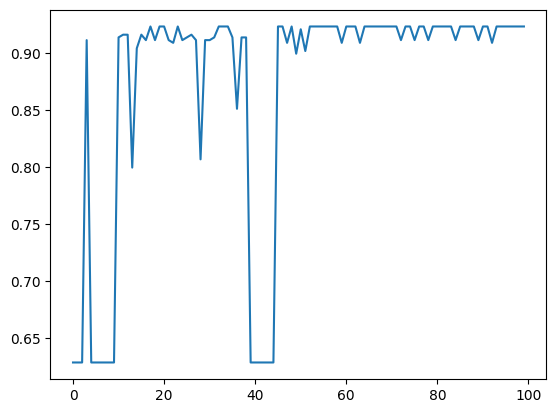

In [35]:
# Bayesian search 결과 시각화 (데이터 추가 경우)
import pandas as pd

print("\nbayesian Search : ", bayesian_model_2.best_score_)

df = pd.DataFrame(bayesian_model_2.cv_results_)
bayesian_score = df['mean_test_score']

plt.plot(bayesian_score)

In [ ]:
# 베이지안과 성능이 같다.

0.8024691358024691


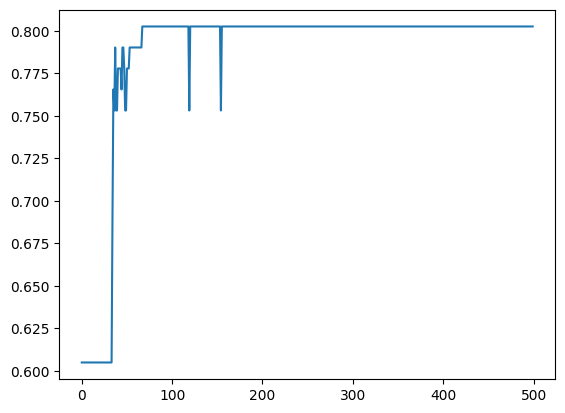

In [40]:
# DQL을 활용해서 비슷한 데이터(유방암 데이터 -> 심장병 데이터)가 되었을 때도 잘 동작하는지 확인

import matplotlib.pyplot as plt
scores, max_score, dones = h2y2_optimization('CNN_LSTM_WEIGHTS_100episodes_10000max_t.pt', 100, new=True)

print(max_score)
plt.plot(scores)

# 10초
# 0.8024691358024691

0.9629629629629629


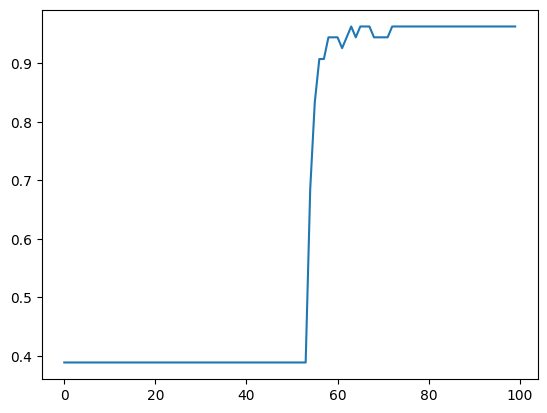

In [46]:
# DQL을 활용해서 아예 다른 데이터(와인 종류 분류 데이터)가 되었을 때도 잘 동작하는지 확인

import matplotlib.pyplot as plt
scores, max_score, dones = h2y2_optimization('CNN_LSTM_WEIGHTS_100episodes_10000max_t.pt', 100, new=True)

print(max_score)
plt.plot(scores)

# 10초
# 0.9629629629629629


bayesian Search :  0.8361308677098152


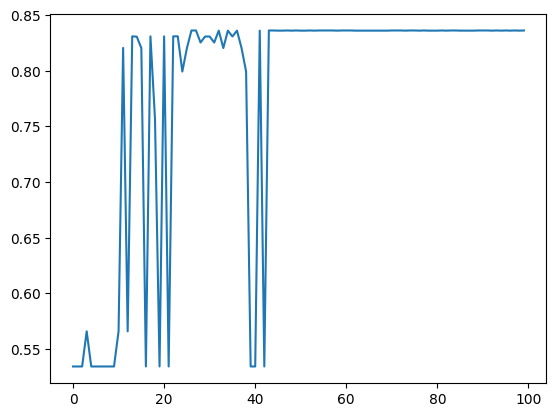

In [16]:
# 바뀐 데이터셋으로 베이지안 최적화 성능 측정 (비슷한 도메인인 경우 - 심장병 진단 데이터)

from skopt import BayesSearchCV

data = pd.read_csv('./data/Heart_Disease_Prediction.csv')
x_data = data.drop(['Heart Disease'], axis=1)
y_data = data['Heart Disease']
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

Bayesian_search = {'n_estimators': list(map(int,(np.linspace(10,1000,100)))),
               'max_depth': list(map(int,np.linspace(2,100,98))),
               'min_samples_leaf': list(map(int, np.linspace(1,100,99))),
               'min_samples_split': list(map(int,np.linspace(2,100,98))),
               'min_weight_fraction_leaf': list(np.linspace(0.1,0.5,5)),
               'min_impurity_decrease': list(np.linspace(0.1,0.9,9)),
               }

clf = RandomForestClassifier(random_state=42)

bayesian_model_3 = BayesSearchCV(
    clf,
    Bayesian_search,
    n_iter=100,
    random_state=42,
    scoring='accuracy',
)

bayesian_model_3.fit(train_x, train_y)

# Bayesian search 결과 시각화
import matplotlib.pyplot as plt
import pandas as pd

print("\nbayesian Search : ", bayesian_model_3.best_score_)

df = pd.DataFrame(bayesian_model_3.cv_results_)
bayesian_score = df['mean_test_score']


plt.plot(bayesian_score)

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 iteration을 100번 돌렸을 때,
# 시간은 6분 42초가 소요된다.
# 정확도는 Bayesian Search :  0.8024691358024691



bayesian Search :  0.968


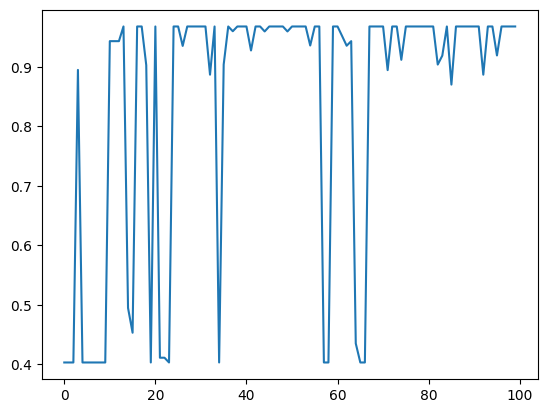

In [17]:
# 바뀐 데이터셋으로 베이지안 최적화 성능 측정 (다른 도메인인 경우 - 와인 분류 데이터)

from skopt import BayesSearchCV

data = load_wine()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

Bayesian_search = {'n_estimators': list(map(int,(np.linspace(10,1000,100)))),
               'max_depth': list(map(int,np.linspace(2,100,98))),
               'min_samples_leaf': list(map(int, np.linspace(1,100,99))),
               'min_samples_split': list(map(int,np.linspace(2,100,98))),
               'min_weight_fraction_leaf': list(np.linspace(0.1,0.5,5)),
               'min_impurity_decrease': list(np.linspace(0.1,0.9,9)),
               }

clf = RandomForestClassifier(random_state=42)

bayesian_model_4 = BayesSearchCV(
    clf,
    Bayesian_search,
    n_iter=100,
    random_state=42,
    scoring='accuracy',
)

bayesian_model_4.fit(train_x, train_y)

# Bayesian search 결과 시각화
import pandas as pd

print("\nbayesian Search : ", bayesian_model_4.best_score_)

df = pd.DataFrame(bayesian_model_4.cv_results_)
bayesian_score = df['mean_test_score']

plt.plot(bayesian_score)

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 iteration을 100번 돌렸을 때,
# 시간은 7분 15초가 소요된다.
# 정확도는 Bayesian Search : 0.9629629629629629


In [ ]:
# DQL을 활용해서 파인튜닝만으로 다른 데이터에서 잘 동작하는지 확인

